In [42]:
import sys
sys.path.append('../input/timmmaster')
import timm

In [43]:
# Preliminaries
from tqdm import tqdm
import math
import random
import os
import pandas as pd
import numpy as np

# Visuals and CV2
import cv2

# albumentations for augs
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

#torch
import torch
import timm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader


import gc
import matplotlib.pyplot as plt
import cudf
import cuml
import cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml import PCA
from cuml.neighbors import NearestNeighbors

In [44]:
# configuration class

class CFG:
    loss_module='ArcFace'
    TRAIN_DIR='../input/shopee-product-matching/train_images'
    TEST_DIR='../input/shopee-product-matching/test_images'
    seed = 123 
    img_size = 512
    classes = 11014
    fc_dim = 512
    epochs = 25
    batch_size = 12
    num_workers = 3
    model_name = 'tf_efficientnet_b3'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_path_arcface='../input/pretrained-b3/Train_F1_score_0.9061769859813084valid_f1_score0.4245035046728972_Epoch_0_lr_start_2.23e-05_lr_max_0.00016_softmax_512x512_tf_efficientnet_b0.pt'
    model_path_softmax = '../input/label-classfier-model/2022-04-15_softmax_512x512_tf_efficientnet_b4.pt'
    # # check true when we want to train the model
    isTraining=False

## Loading Data

In [45]:
def read_dataset():

    # if not in testing phase read train dataset else test dataset
    df = pd.read_csv('../input/shopee-product-matching/train.csv')
    # we have information that label_group is same for similar kind of product
    # let's use this to get F1 score for our final model
    tmp = df.groupby(['label_group'])['posting_id'].unique().to_dict()
    df['matches'] = df['label_group'].map(tmp)
    df['matches'] = df['matches'].apply(lambda x: ' '.join(x))
    # get cuda frame for faster GPU computation
    df_cu = cudf.DataFrame(df)
    
        
    return df, df_cu

## Create Dataset

In [46]:
class ShopeeQueryDataset(Dataset):
    
    def __init__(self, imagePath, transform=None):
        self.imagePath = imagePath
        self.transform = transform
    
    def __len__(self):
        return len(self.imagePath)
    
    def __getitem__(self, idx):
 
        row = self.imagePath[idx]
        # read image convert to RGB and apply augmentation
        image = cv2.imread(row)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply transformation
        if self.transform:
            aug = self.transform(image=image)
            image = aug['image']
        
        return image, torch.tensor(1).long()

In [47]:
def get_test_transforms():

    return albumentations.Compose(
        [
            albumentations.Resize(CFG.img_size,CFG.img_size,always_apply=True),
            albumentations.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

## Model

### Model 1 : Product Classfier Softmax Loss

In [48]:
class ShopeeLabelGroupClassfier(nn.Module):
    
    def __init__(self,
                     model_name='tf_efficientnet_b0',
                     loss_fn='softmax',
                     classes = CFG.classes,
                     fc_dim = CFG.fc_dim,
                     pretrained=False,
                     use_fc=True,
                     isTraining=False
                ):
        
        
        super(ShopeeLabelGroupClassfier,self).__init__()
        
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.use_fc = use_fc
        self.loss_fn =loss_fn
        self.isTraining = isTraining
        
        if self.use_fc:
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(in_features,fc_dim )
            self.bn = nn.BatchNorm1d(fc_dim)
            in_features = fc_dim
        self.loss_fn = loss_fn
        
        if self.loss_fn=='softmax':
            self.final = nn.Linear(in_features, CFG.classes)
    
    def forward(self, image, label):
        features = self.get_features(image)
        if self.loss_fn=='softmax' and CFG.isTraining:
            logits = self.final(features)
            return logits
        else:
            return features
    
    def get_features(self,inp):
        batch_dim = inp.shape[0]
        inp = self.backbone(inp)
        inp = self.pooling(inp).view(batch_dim, -1)
        if self.use_fc and self.isTraining:
            inp = self.dropout(inp)
            inp = self.fc(inp)
            inp = self.bn(inp)
        return inp

### Model 2: Product Classfier ArcFace Loss

In [49]:
class ArcFaceModule(nn.Module):
    def __init__(self, in_features, out_features, scale, margin, easy_margin=False, ls_eps=0.0 ):
        super(ArcFaceModule, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin=easy_margin
        self.ls_eps=ls_eps
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin
        
        
        
    
    def forward(self, input, label):
        
        # cosine = X.W = ||X|| .||W|| . cos(theta) 
        # if X and W are normalize then dot product X, W = will be cos theta
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        # phi = cos(theta + margin) = cos theta . cos(margin) -  sine theta .  sin(margin)
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
            
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        # one hot encoded
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        #  output = label == True ? phi : cosine  
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        # scale the output
        output *= self.scale
        # return cross entropy loss on scalled output
        return output, nn.CrossEntropyLoss()(output,label)

In [50]:
   
class ShopeeEncoderBackBone(nn.Module):
    
    def __init__(self,
                     model_name='tf_efficientnet_b3',
                     loss_fn='ArcFace',
                     classes = CFG.classes,
                     fc_dim = CFG.fc_dim,
                     pretrained=False,
                     use_fc=True,
                     isTraining=False
                ):
        
        
        super(ShopeeEncoderBackBone,self).__init__()
        
        # create bottlenack backbone network from pretrained model 
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.use_fc = use_fc
        self.loss_fn =loss_fn
        self.isTraining =isTraining
        
        # build top fc layers (Embedding that we are looking at testing time to represent the entire image)
        # this will work as regularizer
        if self.use_fc:
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(in_features,fc_dim )
            self.bn = nn.BatchNorm1d(fc_dim)
            self.init_params()
            in_features = fc_dim
        self.loss_fn = loss_fn
        if self.loss_fn=='softmax':
            self.final = nn.Linear(in_features, CFG.classes)
        elif self.loss_fn =='ArcFace':
            self.final = ArcFaceModule( in_features,
                                        CFG.classes,
                                        scale = 30,
                                        margin = 0.5,
                                        easy_margin = False,
                                        ls_eps = 0.0)
            
    def forward(self, image, label):
        features = self.get_features(image)
        if self.isTraining:
            logits = self.final(features, label)
            return logits
        else:
            return features
    
    def init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias,0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)
        
        
    def get_features(self,inp):
        batch_dim = inp.shape[0]
        inp = self.backbone(inp)
        inp = self.pooling(inp).view(batch_dim, -1)
        if self.use_fc and self.isTraining:
            inp = self.dropout(inp)
            inp = self.fc(inp)
            inp = self.bn(inp)
            
        return inp

In [51]:
# Load trained model

def getPretrainedModel(loss_module='ArcFace', model_path=CFG.model_path_arcface, device=CFG.device) :
    
    if loss_module== 'ArcFace':
        # load arcface loss classfier
        model = ShopeeEncoderBackBone()
        model.load_state_dict(torch.load(CFG.model_path_arcface, map_location=CFG.device))
        model = model.to(CFG.device)
        return model
    else:
        #load softmax classfier
        model = ShopeeLabelGroupClassfier()
        model.load_state_dict(torch.load(CFG.model_path_softmax, map_location=CFG.device))
        model = model.to(CFG.device)
        return model

## Generate Embeddings

In [52]:
def get_images_path(df, root_dir,isRandomImage=False):
    if not isRandomImage:
        imagepaths = [ root_dir + "/"+image for image in df['image'].tolist()]
        return imagepaths
    else :
        return []

In [53]:
def getEmbeddings(queryImagesPath, model, transform=None):
    # create dataset from image paths
    query_dataset = ShopeeQueryDataset(queryImagesPath,  transform = transform)
    
    # create dataloader
    query_dataloader = torch.utils.data.DataLoader(
                                                query_dataset,
        batch_size=16
    )
    
    
    # put model in evaluation mode
    model.eval()
    embeddings = []
    with torch.no_grad():
         
        for idx, datax  in tqdm(enumerate(query_dataloader)):
            image, label = datax
            image = image.to(CFG.device)
            label = label.to(CFG.device)
            # forward pass to get features
            features = model(image, label)
            image_embeddings = features.detach().cpu().numpy()
            embeddings.append(image_embeddings)
            
            
    image_embeddings = np.concatenate(embeddings)
            
    return image_embeddings

In [54]:
def get_neighbors( train_embeddings, query_embeddings,KNN=50, metric_param='cosine'):
    # we can get top neighbors based on different distance metric,in our case we are using 
    # cosine and euclidean metric
    if metric_param == 'cosine':
        # fit cosine distance medal on train image embddings
        cosine_knnModel = get_knn_model(train_embeddings, KNN=KNN, metric='cosine')
        # get top k neighbors distances and indices given metric for query embeddings
        distances, indices = cosine_knnModel.kneighbors(query_embeddings)

    else:
        # fit euclidean distance modal on image embeddings
        eucl_knnModel = get_knn_model(train_embeddings, KNN=KNN, metric='minkowski')
        # get top k neighbors distances and indices given metric for query embeddings
        distances, indices = eucl_knnModel.kneighbors(query_embeddings)
    
    return distances, indices

In [55]:
# get nearest neighbors distances and index information

def get_knn_model(embeddings,KNN=50, metric='cosine'):
    knnModel = NearestNeighbors(n_neighbors=KNN,metric=metric)
    knnModel.fit(embeddings)
#         distances, indices = knnModel.kneighbors(image_embeddings)
    
    return knnModel

In [56]:
train_df = pd.read_csv('../input/shopee-product-matching/train.csv')
# get  Training image  path
train_image_paths = get_images_path(train_df, CFG.TRAIN_DIR)

In [57]:
#  get Training Image embeddings and save it for later use
test_transform =get_test_transforms()
shopee_model = getPretrainedModel(loss_module='ArcFace',model_path=CFG.model_path_arcface, device=CFG.device)
train_image_embeddings = getEmbeddings(train_image_paths, shopee_model, transform=test_transform)
np.save("training_image_embeddings", train_image_embeddings)

3it [00:01,  1.72it/s]


KeyboardInterrupt: 

### Let's get Query Embeddings 

In [ ]:
train_image_embeddings.shape

In [ ]:
from os import listdir
from os.path import isfile, join
TEST_DIR='../input/sample-testing'
test_images_list = [join(TEST_DIR, f) for f in listdir(TEST_DIR) if isfile(join(TEST_DIR, f))]

test_images_list

In [ ]:
query_image_embeddings = getEmbeddings(test_images_list, shopee_model, transform=test_transform)


In [ ]:
metric_param = 'cosine'
query_cosine_distances, query_cosine_indices = get_neighbors(
                                    train_embeddings = train_image_embeddings,
                                    query_embeddings = query_image_embeddings,
                                    KNN=50,
                                    metric_param='cosine'
                                )

print(query_cosine_distances.shape)
print(query_cosine_indices.shape)

### Let's visualize our Model Results

In [58]:


def plot_canvas(train, COLS=4, ROWS=2, path=CFG.TRAIN_DIR+"/",img_list=[],k=0):
    
    for m in range(ROWS): 
        plt.figure(figsize=(20,5))
        for j in range(COLS): 
            if j == 0 and m == 0:
                title = "Query Image \n"
                title += "Downloaded from internet : \n"
                img = cv2.imread(img_list[k])
            else:
                row = COLS*m + j 
                name = train.iloc[row-1,1]
                img = cv2.imread(path+name)

                title = "Recommended Image {} \n".format(row-1)
                orig_title = train.iloc[row-1,3]
                punctuation= '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
                for x in punctuation:
                    orig_title=orig_title.replace(x,"")
                title  += "title :" + orig_title[:min(15, len(orig_title))] + " \n"
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB )
            plt.subplot(1,COLS,j+1)
            plt.title(title)
            plt.axis('off')
            plt.imshow(img)
        plt.show()



## Visualize Top k Recommendation

### Visualize Results based on Cosine Distance

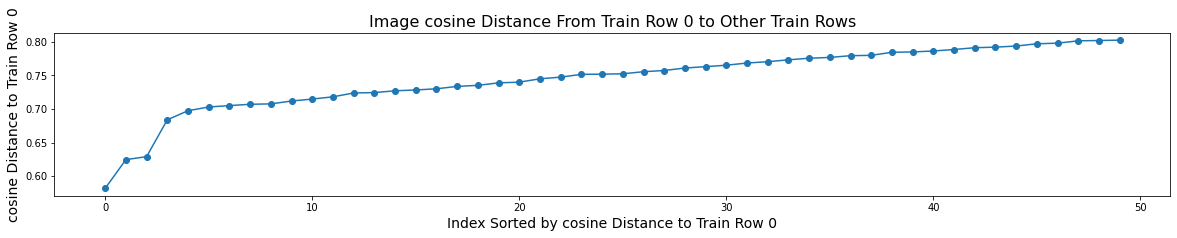

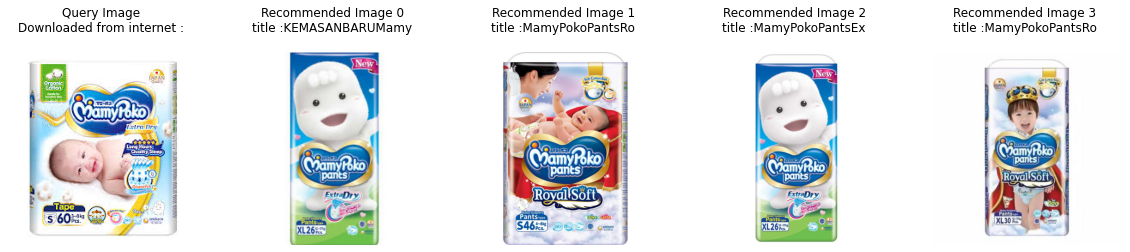

In [59]:
for k in range(1):

    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50),cupy.asnumpy(query_cosine_distances[k,]),'o-')
    plt.title('Image {} Distance From Train Row {} to Other Train Rows'.format("cosine",k),size=16)
    plt.ylabel('{} Distance to Train Row {}'.format("cosine", k),size=14)
    plt.xlabel('Index Sorted by {} Distance to Train Row {}'.format("cosine",k),size=14)
    plt.show()
    
    cluster = train_df.loc[cupy.asnumpy(query_cosine_indices[k,:8])] 
    plot_canvas(cluster, COLS=5, ROWS=1, path=CFG.TRAIN_DIR+"/",img_list=test_images_list,k=k)
#     plot_canvas(cluster, random=False, ROWS=2, COLS=4, isRecommending=True, test_images_list=test_images_list,k=k)

### Visualize Results based on Euclidean Distance

In [ ]:

query_euc_distances, query_euc_indices = get_neighbors(
                                    train_embeddings = train_image_embeddings,
                                    query_embeddings = query_image_embeddings,
                                    KNN=50,
                                    metric_param='euclidean'
                                )



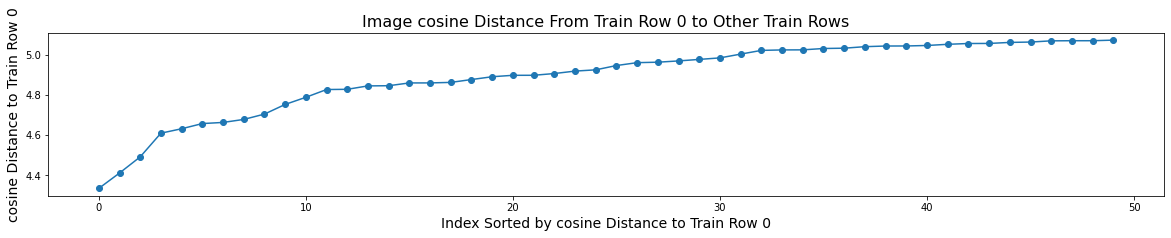

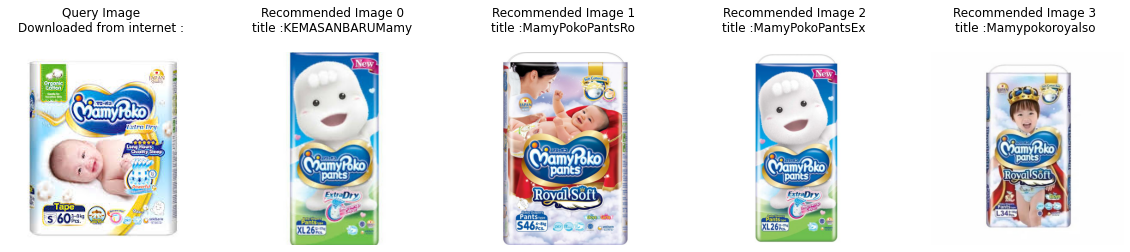

In [60]:
for k in range(1):

    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50),cupy.asnumpy(query_euc_distances[k,]),'o-')
    plt.title('Image {} Distance From Train Row {} to Other Train Rows'.format("cosine",k),size=16)
    plt.ylabel('{} Distance to Train Row {}'.format("cosine", k),size=14)
    plt.xlabel('Index Sorted by {} Distance to Train Row {}'.format("cosine",k),size=14)
    plt.show()
    
    cluster = train_df.loc[cupy.asnumpy(query_euc_indices[k,:8])] 
    plot_canvas(cluster, COLS=5, ROWS=1, path=CFG.TRAIN_DIR+"/",img_list=test_images_list,k=k)
    #plot_canvas(cluster, random=False, ROWS=2, COLS=4, isRecommending=True, test_images_list=test_images_list,k=k)